# Lab Assignment Six: Convolutional Neural Network (CNN) Architectures
### Lab six report submission for CS7324_SP21

## Team members: Jinyu Du, Hessam Emami 


### An overview of the dataset
The casting manufacturing product image dataset downloaded from Kaggle was chosen for lab 6 (the same dataset was used for lab 2). 

### Business overview
In quality control, performing quality inspection of casting using product image data is a novel approach that combines machine vision and computer vision techniques. Machine vision is an engineering-based system where machines mechanically "watch" the production line's steps [1]. It plays a significant role in the manufacturing and logistics quality control process. In recent years, the emergence and advances of computer vision are making machines more intelligent and "see" better. Computer vision is at the core of machine vision. "If we think of machine vision as the body of a system, computer vision is the retina, optic nerve, brain, and central nervous system. A machine vision system uses a camera to view an image, computer vision algorithms then process and interpret the image, before instructing other components in the system to act upon that data." [1] 

This lab project develops convolutional neural network (CNN) models that classify casting products into "ok" and "defective" categories according to product image data. The results will provide business insights for modern-day manufacturing's quality control process. An efficient and accurate machine learning algorithm using image recognition for quality control will improve manufacturing productivity.   


#### Purpose of the data
The dataset owner collected the data to automate and monitor casting defect prediction using deep learning classification models. Pilot Technocast, Shapar, Rajkot supported Their work. 

Our team intends to apply image recognition techniques to this image dataset for casting defects prediction. 

The dataset can be accessed from here:
<p><a title="Casting product image data for quality inspection" href="https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product"> Casting product image data for quality inspection</a></p>

Dataset Author: <a title="Ravirajsinh Dabhi" href="https://www.kaggle.com/ravirajsinh45">Ravirajsinh Dabhi</a>

This dataset includes 1300 photo images of top views of the submersible pump impeller. Each image is $512\times 512$ pixels grey-scaled without augmentation. 

The images fall into two categories: defective and ok. They are split into training and testing datasets, each of which contains defective and ok images.

### Measure the performance

The most common casting defect categories are cold shuts, gas porosity, shrinkage porosity, and hot tears. Image processing is one method that can detect defects and can be customized to provide higher defect detection performance for each category. In this lab, we have generic CNN models to detect the flaws. Models with high performance are required for defect detection in each target class.
In industry, casting products can be used in sensitive parts, and quality assurance to accept a casting delivery has high standards. Commonly, the whole shipment is rejected due to a few defective items. Hence, it is essential to minimize false positives for casting prediction to reduce rework. Moreover, if bad castings are not recognized and sent to customers, it causes more detrimental effects than treating good castings as defective ones. For example, if customers use bad castings, it may cause incidents or even life-threatening issues. Therefore, reducing the number of false negatives is the primary goal for our model, and recall value should be the primary metric to evaluate algorithms' performance[2]. A higher recall is equivalent to lower false-negative rates. In addition, accuracy is a secondary measure for model performance when the recall values are comparable. McNemar tests will compare models statistically.

### Create Training and Testing dataset

The dataset does not depend on time, and the target classes are roughly balanced. Considering the size of the dataset and the computational demands, we believe stratified k-fold cross-validation with an 80/20 split is a reasonable approach to create training and testing datasets. To train and test our models, we create three-fold stratified cross-validation datasets, and the ratio is 80/20 between the training and testing sets. Stratification guarantees that both the training and testing datasets have the same proportion of 'ok' and 'defective' castings as that in the original dataset. Moreover, three-fold is sufficient for cross-validation purposes, and it is not too demanding on computational power. The ratio of 80/20 is typical, and it is appropriate for splitting the dataset. 


In [5]:
from ipywidgets import widgets 

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import os
import pandas as pd
from PIL import Image

import seaborn as sns
from skimage.io import imshow
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar

import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.layers import Reshape, Add, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import average 
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import  Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

keras.__version__

'2.4.0'

## Popluate the dataset

This dataset includes two sets of images. In this notebook, we use 512x512 images as they are not augmented. Each set has two folders: "ok_front" and "def_front", which contain good/ok and defective products, respectively. In the following code section, we load all the folders' images.

In [6]:
def_directory = '/floyd/input/ds/_512x512/def_front/'
ok_directory = '/floyd/input/ds/_512x512/ok_front/'

Two image lists are created. We combine them for training and testing dataset and create a list for target values. If the image is found in the "front_ok" folder, its targe value will be assigned "0". Otherwise, the value will be "1".

In [7]:
#https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays
# size of the image is 512*512

h = 512
w = 512

# read in the image data as a numpy array, with each row represent an image
def load_image(directory):
    """ load image data as numpy array, one image per row"""
    files = os.listdir(directory)
    image_list = np.empty((len(files), h * w) , dtype=np.uint8)

    for index, filename in enumerate(files):
         # Images are grayscale  but still they have three channels
         # To reduce the computation size we load them as grayscale image.
        image = Image.open(directory + filename).convert('L')
        image_list[index] = np.asarray(image).reshape(h * w ,)
    return image_list, files

image_def, files_def = load_image(def_directory)
image_ok, files_ok = load_image(ok_directory)
files = np.append(files_def, files_ok)

In [8]:
def populate_ds(def_list, ok_list): # defective is 1, ok is 0
    
    target = np.ones(len(def_list), dtype = int)
    target = np.append(target, np.zeros(len(ok_list), dtype = int))
    data = np.concatenate((def_list, ok_list))  
    
    return (data, target)

data, target = populate_ds(image_def, image_ok)

print('Number of images for defective castings: ', len(image_def))
print('Number of images for ok castings: ', len(image_ok))

print("The size of the image data (one image per row) is: ", data.shape)
print("The size of the target for image data (1 for defective, 0 for ok) is: ", target.shape)

Number of images for defective castings:  781
Number of images for ok castings:  519
The size of the image data (one image per row) is:  (1300, 262144)
The size of the target for image data (1 for defective, 0 for ok) is:  (1300,)


In [9]:
data = np.expand_dims(data.reshape((-1,h,w)), axis=3)
data.shape

(1300, 512, 512, 1)

As we can see, there are 781 "defective" images and 519 "ok" images in the dataset. There are 1300 in total. The size of each image is $(512 \times 512 \times 1)$ and the channel is 1.

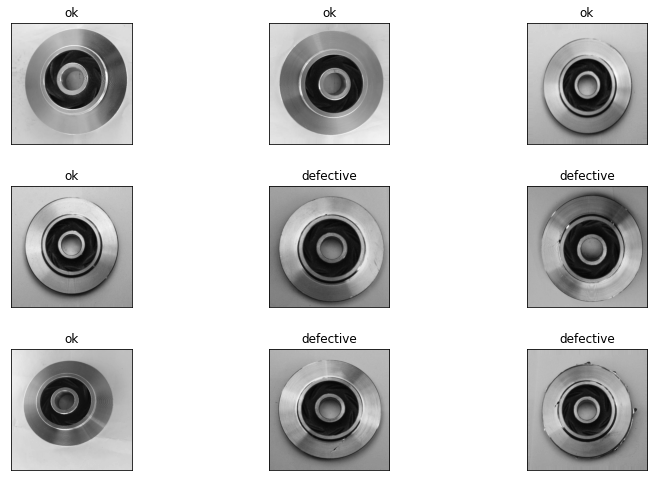

In [10]:
class_type = ['ok' , 'defective']
def print_class(class_type, index):
    return class_type[index]

def plot_gallery(images, titles, h, w, convertor = None, types = class_type, n_row=3, n_col=3):
    
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=2, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        index = np.random.choice(len(images))
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(data[index].squeeze(),cmap=plt.cm.gray)
        if convertor:
            title = convertor(types, titles[index])
        else:
            title = titles[index]
        plt.title(title, size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(data, target, h, w, convertor= print_class, types = class_type)

The above plot shows nine sample images with corresponding class names.

### Normalizing data

In [11]:
ss = StandardScaler()
tmp = data.reshape(len(data), h*w)
normalized_data = ss.fit_transform(tmp)
normalized_data.shape

(1300, 262144)

In [12]:
img_wh = 512
X = normalized_data.reshape(len(data), img_wh, img_wh, 1)
X.shape

(1300, 512, 512, 1)

In [13]:
NUM_CLASSES = 2
target_ohe = keras.utils.to_categorical(target, NUM_CLASSES)

### Splitting the dataset into training and testing datasets

In [14]:
num_cv_iterations = 3
cv_object = StratifiedShuffleSplit(n_splits=num_cv_iterations,
                         test_size=0.2, 
                         random_state=7324)
print(cv_object)

StratifiedShuffleSplit(n_splits=3, random_state=7324, test_size=0.2,
            train_size=None)


In [15]:
labels = ["ok", "defective"]

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(9,3))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    classification_report_values = mt.classification_report(y_test,yhat)
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels,yticklabels=labels)
    plt.title(title_text+'{:.4f}'.format(acc))
    return classification_report_values

### Data expansion

In [16]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.05, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.05, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

datagen.fit(X)

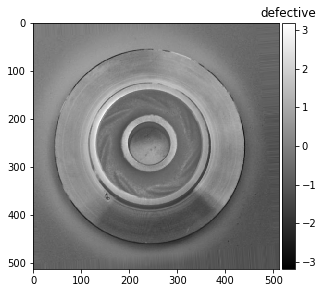

In [17]:
tmps = datagen.flow(X, target_ohe, batch_size=1, seed=7324)

for tmp in tmps:
    imshow(tmp[0].squeeze(), cmap=plt.cm.gray)
    plt.title(labels[np.argmax(tmp[1])])
    break

The data expansion is performed using ImageDataGenerator. We set rotation_range as 5 degrees for random rotations. This argument is valid because the castings are round, so theoretically, rotation of any degree should be valid.

In [18]:
#Set labmda 
l2_lambda = 0.000001

## Model 1 - resnet1

In [19]:
%%time

# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32/8,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32/8,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64/8,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64/8,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=32/8,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet1 = Model(inputs=input_holder,outputs=x)

resnet1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 4)  40          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 4)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 4)  148         max_pooling2d[0][0]              
______________________________________________________________________________________________


Results for cross-validation set 1
Epoch 1/150
17/17 [==============================] - 77s 1s/step - loss: 4.3537 - accuracy: 0.6219 - val_loss: 1.0665 - val_accuracy: 0.6154
Epoch 2/150
17/17 [==============================] - 18s 1s/step - loss: 0.8235 - accuracy: 0.7202 - val_loss: 0.5087 - val_accuracy: 0.7115
Epoch 3/150
17/17 [==============================] - 18s 1s/step - loss: 0.5369 - accuracy: 0.7371 - val_loss: 0.4800 - val_accuracy: 0.7577
Epoch 4/150
17/17 [==============================] - 18s 1s/step - loss: 0.4763 - accuracy: 0.7750 - val_loss: 0.4646 - val_accuracy: 0.7615
Epoch 5/150
17/17 [==============================] - 19s 1s/step - loss: 0.4673 - accuracy: 0.7994 - val_loss: 0.4441 - val_accuracy: 0.7808
Epoch 6/150
17/17 [==============================] - 19s 1s/step - loss: 0.4411 - accuracy: 0.8009 - val_loss: 0.4533 - val_accuracy: 0.7692
Epoch 7/150
17/17 [==============================] - 19s 1s/step - loss: 0.4741 - accuracy: 0.7699 - val_loss: 0.4765 

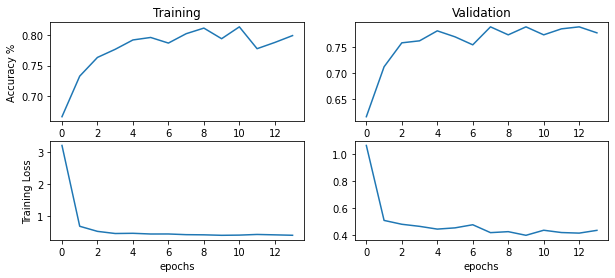

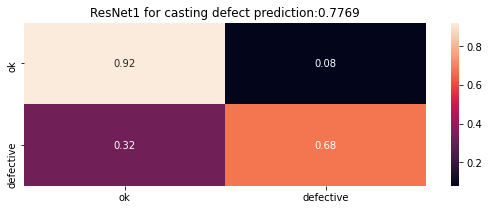

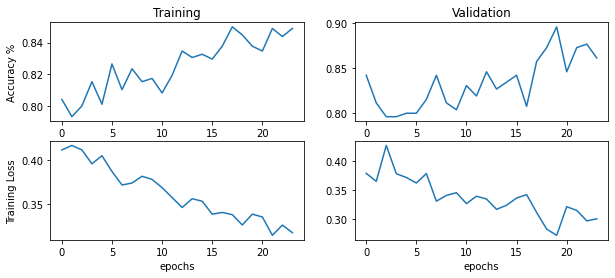

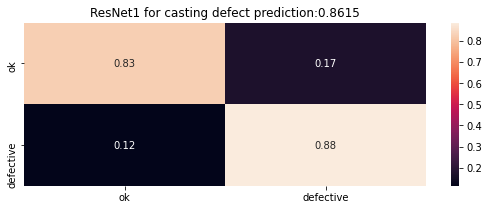

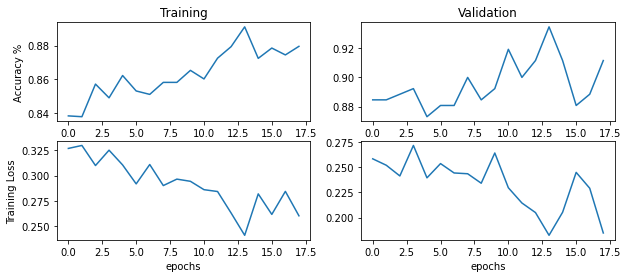

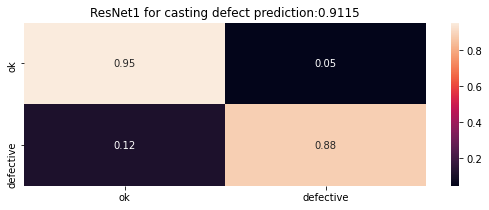

In [20]:
%%time 

resnet1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

cv_val_accuracy_resnet1 = [] # this stores the val_accuracy for resnet1 from all cross_validation
cr_rs1 = None
cv_yhat_vec_resnet1 = [] # this stores the yhat_vec from all cross_validation

i = 0 
for train_index, test_index in cv_object.split(X, target):
    print()
    print("Results for cross-validation set", i+1)
    i +=1
    
    X_train, X_test = X[train_index], X[test_index]
    y_train,  y_test = target[train_index], target[test_index]
    
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

    history = resnet1.fit(datagen.flow(X_train, y_train_ohe, batch_size=60, seed=7324), 
                      steps_per_epoch=int(len(X_train)/60), # how many generators to go through per epoch
                      epochs=150, verbose=1,
                      shuffle=True,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)])   
    
    yhat = np.round(resnet1.predict(X_test)) # yhat is one-hot encoded prediction of y
    yhat_vec = [] # yhat_vec stores prediction of y in a vector form
    
    # change yhat from one-hot encoded form to a vector form
    for j in range(len(yhat)):
        if yhat[j][1] == 1:
            yhat_vec.append(1)
        else:
            yhat_vec.append(0)
            
    cv_yhat_vec_resnet1.append(yhat_vec)

    
    cv_val_accuracy_resnet1.append(history.history['val_accuracy'])

    
    plt.figure(figsize=(10,4))
    
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'])
    plt.ylabel('Accuracy %')
    plt.title('Training')
    
    plt.subplot(2,2,2)
    plt.plot(history.history['val_accuracy'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    
    cr_rs1 = summarize_net(resnet1, X_test, y_test, title_text='ResNet1 for casting defect prediction:')
    
    if (i == num_cv_iterations):
      print('classification_report:\n', cr_rs1 )
    
    print()
    print()


## Model 2 - resnet2

The number of filters in convolutional layers in resnet2 is four times those in resnet1. Also, pool size in restnet2 is (4, 4) compared to (2, 2) pool size in resnet1.

In [21]:
%%time

### major difference between ResNet2 and ResNet1
# pool_size = (4, 4) instead of (2, 2)

l2_lambda = 0.000001
input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32/2,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(4, 4), data_format="channels_last")(x)

x = Conv2D(filters=32/2,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(4, 4), data_format="channels_last")(x)

x = Conv2D(filters=64/2,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64/2,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=32/2,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet2 = Model(inputs=input_holder,outputs=x)

resnet2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 512, 512, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 16) 2320        max_pooling2d_3[0][0]            
____________________________________________________________________________________________


Results for cross-validation set 1
Epoch 1/150
17/17 [==============================] - 21s 1s/step - loss: 10.4914 - accuracy: 0.5299 - val_loss: 0.9564 - val_accuracy: 0.7231
Epoch 2/150
17/17 [==============================] - 19s 1s/step - loss: 0.9205 - accuracy: 0.6798 - val_loss: 0.5625 - val_accuracy: 0.6846
Epoch 3/150
17/17 [==============================] - 19s 1s/step - loss: 0.5345 - accuracy: 0.7458 - val_loss: 0.5218 - val_accuracy: 0.7038
Epoch 4/150
17/17 [==============================] - 19s 1s/step - loss: 0.5187 - accuracy: 0.7210 - val_loss: 0.4958 - val_accuracy: 0.7269
Epoch 5/150
17/17 [==============================] - 19s 1s/step - loss: 0.4920 - accuracy: 0.7691 - val_loss: 0.4795 - val_accuracy: 0.7385
Epoch 6/150
17/17 [==============================] - 19s 1s/step - loss: 0.4655 - accuracy: 0.7636 - val_loss: 0.4543 - val_accuracy: 0.7538
Epoch 7/150
17/17 [==============================] - 19s 1s/step - loss: 0.4435 - accuracy: 0.8056 - val_loss: 0.4478

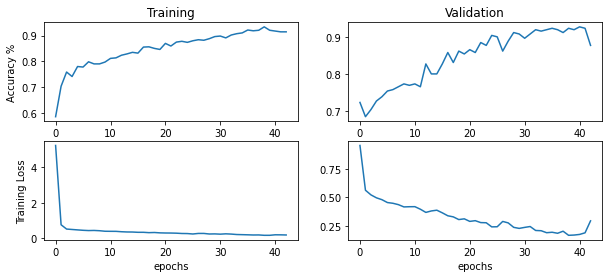

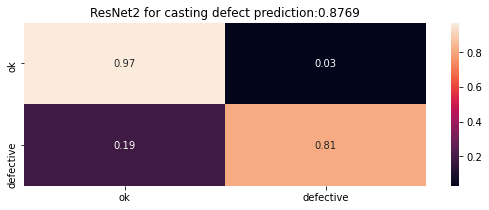

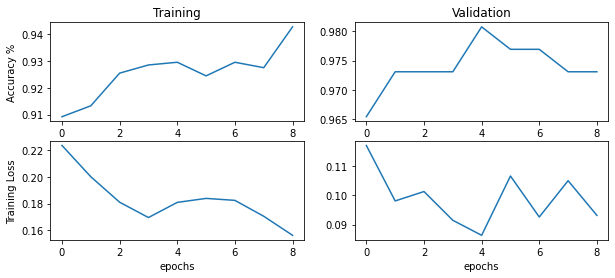

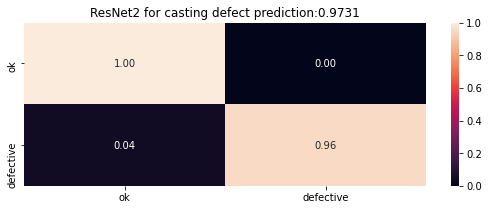

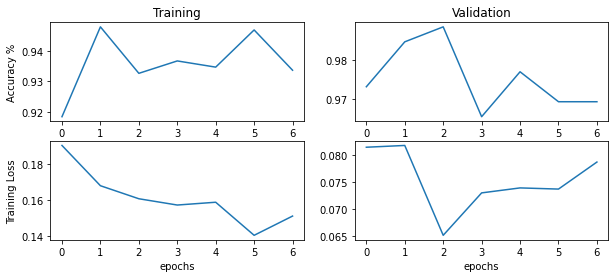

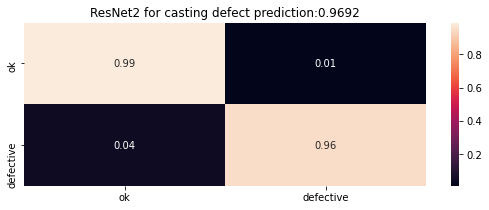

In [22]:
%%time 

resnet2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

cv_val_accuracy_resnet2 = [] # this stores the val_accuracy for resnet2 from all cross_validation
cr_restnet2 = None
cv_yhat_vec_resnet2 = [] # this stores the yhat_vec from all cross_validation

i = 0 
for train_index, test_index in cv_object.split(X, target):
    
    print()
    print("Results for cross-validation set", i+1)
    i +=1
    
    X_train, X_test = X[train_index], X[test_index]
    y_train,  y_test = target[train_index], target[test_index]
    
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

    history = resnet2.fit(datagen.flow(X_train, y_train_ohe, batch_size=60, seed=7324), 
                      steps_per_epoch=int(len(X_train)/60), # how many generators to go through per epoch
                      epochs=150, verbose=1,
                      shuffle=True,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)])   
    
    yhat = np.round(resnet2.predict(X_test)) # yhat is one-hot encoded prediction of y
    yhat_vec = [] # yhat_vec stores prediction of y in a vector form
    
    # change yhat from one-hot encoded form to a vector form
    for j in range(len(yhat)):
        if yhat[j][1] == 1:
            yhat_vec.append(1)
        else:
            yhat_vec.append(0)
            
    cv_yhat_vec_resnet2.append(yhat_vec)
    
    cv_val_accuracy_resnet2.append(history.history['val_accuracy'])
    
    plt.figure(figsize=(10,4))
    
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'])
    plt.ylabel('Accuracy %')
    plt.title('Training')
    
    plt.subplot(2,2,2)
    plt.plot(history.history['val_accuracy'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    
    cr_restnet2 = summarize_net(resnet2, X_test, y_test, title_text='ResNet2 for casting defect prediction:')

    if (i == num_cv_iterations):
      print('classification_report:\n', cr_restnet2 )

    print()
    print()


## Model 3 - xception1
### Xception style architecture

In [23]:
input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32/4,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32/4,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32/4,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32/4,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES,activation="softmax")(x)

xception1 = Model(inputs=input_holder,outputs=x)

xception1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 512, 512, 8)  80          input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 256, 256, 8)  0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 8)  584         max_pooling2d_6[0][0]            
____________________________________________________________________________________________


Results for cross-validation set 1
Epoch 1/150
17/17 [==============================] - 22s 1s/step - loss: 5.8344 - accuracy: 0.6595 - val_loss: 3.9647 - val_accuracy: 0.6615
Epoch 2/150
17/17 [==============================] - 19s 1s/step - loss: 1.8775 - accuracy: 0.7058 - val_loss: 0.5803 - val_accuracy: 0.7154
Epoch 3/150
17/17 [==============================] - 19s 1s/step - loss: 0.6283 - accuracy: 0.6882 - val_loss: 0.4889 - val_accuracy: 0.7577
Epoch 4/150
17/17 [==============================] - 19s 1s/step - loss: 0.4734 - accuracy: 0.7733 - val_loss: 0.4658 - val_accuracy: 0.7885
Epoch 5/150
17/17 [==============================] - 19s 1s/step - loss: 0.4567 - accuracy: 0.7859 - val_loss: 0.4670 - val_accuracy: 0.7615
Epoch 6/150
17/17 [==============================] - 19s 1s/step - loss: 0.4220 - accuracy: 0.8009 - val_loss: 0.4415 - val_accuracy: 0.7731
Epoch 7/150
17/17 [==============================] - 19s 1s/step - loss: 0.4563 - accuracy: 0.7881 - val_loss: 0.4274 

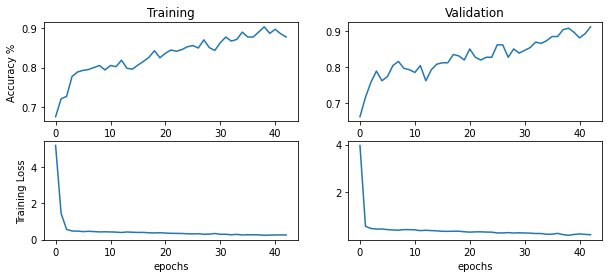

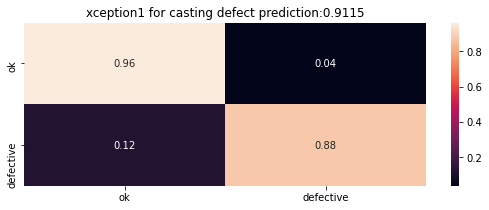

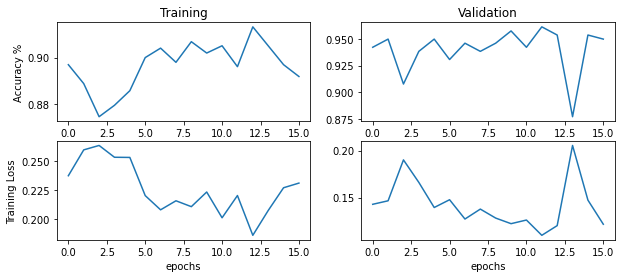

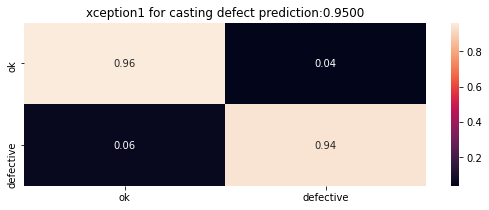

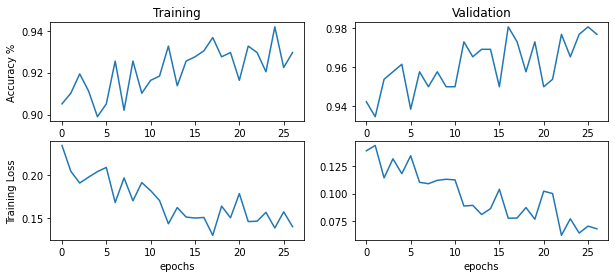

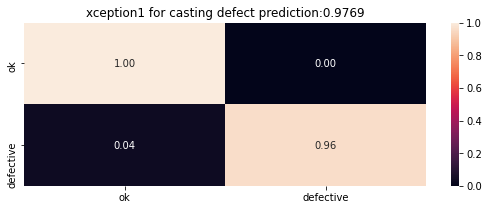

In [24]:
%%time 

xception1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

cv_val_accuracy_xception1 = [] # this stores the val_accuracy for resnet2 from all cross_validation
cr_xception1 = None
cv_yhat_vec_xception1 = [] # this stores the yhat_vec from all cross_validation

i = 0 
for train_index, test_index in cv_object.split(X, target):
    
    print()
    print("Results for cross-validation set", i+1)
    i +=1
    
    X_train, X_test = X[train_index], X[test_index]
    y_train,  y_test = target[train_index], target[test_index]
    
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
    history = xception1.fit(datagen.flow(X_train, y_train_ohe, batch_size=60, seed=7324), 
                      steps_per_epoch=int(len(X_train)/60), # how many generators to go through per epoch
                      epochs=150, verbose=1,
                      shuffle=True,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)])   
    
    yhat = np.round(xception1.predict(X_test)) # yhat is one-hot encoded prediction of y
    yhat_vec = [] # yhat_vec stores prediction of y in a vector form
    
    # change yhat from one-hot encoded form to a vector form
    for j in range(len(yhat)):
        if yhat[j][1] == 1:
            yhat_vec.append(1)
        else:
            yhat_vec.append(0)
            
    cv_yhat_vec_xception1.append(yhat_vec)
    cv_val_accuracy_xception1.append(history.history['val_accuracy'])
   
    plt.figure(figsize=(10,4))
    
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'])
    plt.ylabel('Accuracy %')
    plt.title('Training')
    
    plt.subplot(2,2,2)
    plt.plot(history.history['val_accuracy'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    
    cr_xception1 =  summarize_net(xception1, X_test, y_test, title_text='xception1 for casting defect prediction:')
    
    if (i == num_cv_iterations):
      print('classification_report:\n', cr_xception1 )
   
    print()
    print()


## Model 4 - xception2
### xception2 style architecture

The xception2 has four filters in convolutional layers compared to eight filters in the xception1 model. In addition, pool size in xception2 is set to (4, 4) instead of (2, 2) in xception1.

In [25]:
### major difference between xception2 and xception1
# xception2 decrease (1/2) the number of filters used in xception2
# pool_size = (4, 4) instead of (2, 2)

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32/8,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(4, 4), data_format="channels_last")(x)

x = Conv2D(filters=32/8,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(4, 4), data_format="channels_last")(x)

x = SeparableConv2D(filters=32/8,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32/8,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(4, 4), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES,activation="softmax")(x)

xception2 = Model(inputs=input_holder,outputs=x)

xception2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 512, 512, 4)  40          input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 4)  0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 128, 4)  148         max_pooling2d_9[0][0]            
____________________________________________________________________________________________


Results for cross-validation set 1
Epoch 1/150
17/17 [==============================] - 20s 1s/step - loss: 1.6927 - accuracy: 0.5834 - val_loss: 0.8242 - val_accuracy: 0.6192
Epoch 2/150
17/17 [==============================] - 19s 1s/step - loss: 0.8766 - accuracy: 0.6937 - val_loss: 0.6282 - val_accuracy: 0.6231
Epoch 3/150
17/17 [==============================] - 19s 1s/step - loss: 0.6650 - accuracy: 0.6867 - val_loss: 0.5383 - val_accuracy: 0.6500
Epoch 4/150
17/17 [==============================] - 18s 1s/step - loss: 0.6057 - accuracy: 0.7157 - val_loss: 0.5155 - val_accuracy: 0.7269
Epoch 5/150
17/17 [==============================] - 19s 1s/step - loss: 0.5481 - accuracy: 0.7015 - val_loss: 0.5100 - val_accuracy: 0.6962
Epoch 6/150
17/17 [==============================] - 18s 1s/step - loss: 0.5313 - accuracy: 0.7131 - val_loss: 0.4948 - val_accuracy: 0.7192
Epoch 7/150
17/17 [==============================] - 18s 1s/step - loss: 0.5003 - accuracy: 0.7369 - val_loss: 0.4817 

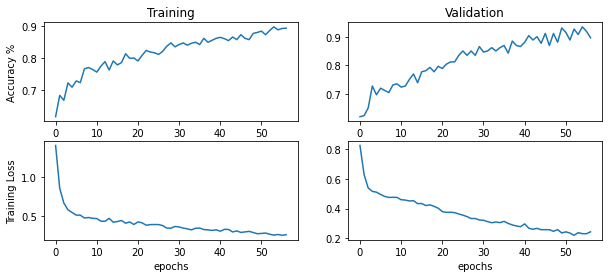

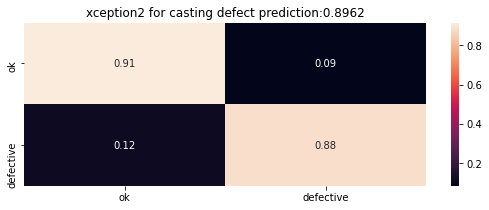

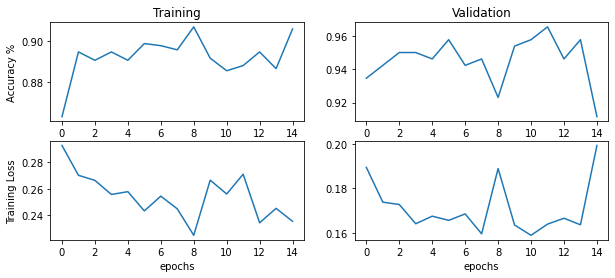

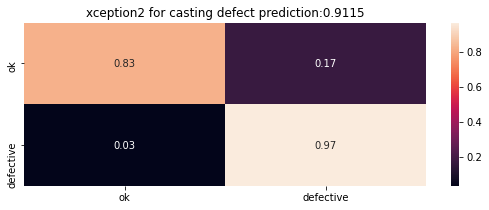

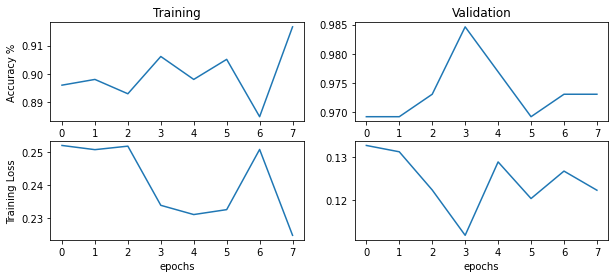

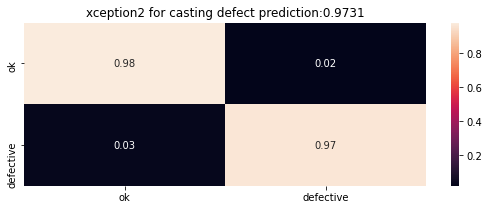

In [26]:
%%time 

xception2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

cv_val_accuracy_xception2 = [] # this stores the val_accuracy for resnet2 from all cross_validation
cr_xception2  = None
cv_yhat_vec_xception2 = [] # this stores the yhat_vec from all cross_validation

i = 0 
for train_index, test_index in cv_object.split(X, target):
    
    print()
    print("Results for cross-validation set", i+1)
    i +=1
    
    X_train, X_test = X[train_index], X[test_index]
    y_train,  y_test = target[train_index], target[test_index]
    
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

    history = xception2.fit(datagen.flow(X_train, y_train_ohe, batch_size=60, seed=7324), 
                      steps_per_epoch=int(len(X_train)/60), # how many generators to go through per epoch
                      epochs=150, verbose=1,
                      shuffle=True,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)])   
    
    yhat = np.round(xception2.predict(X_test)) # yhat is one-hot encoded prediction of y
    yhat_vec = [] # yhat_vec stores prediction of y in a vector form
    
    # change yhat from one-hot encoded form to a vector form
    for j in range(len(yhat)):
        if yhat[j][1] == 1:
            yhat_vec.append(1)
        else:
            yhat_vec.append(0)
            
    cv_yhat_vec_xception2.append(yhat_vec)
    cv_val_accuracy_xception2.append(history.history['val_accuracy'])
    
    plt.figure(figsize=(10,4))
    
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'])
    plt.ylabel('Accuracy %')
    plt.title('Training')
    
    plt.subplot(2,2,2)
    plt.plot(history.history['val_accuracy'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    
    cr_xception2 =  summarize_net(xception2, X_test, y_test, title_text='xception2 for casting defect prediction:')
    
    if (i == num_cv_iterations):
      print('classification_report:\n', cr_xception2 )

    print()
    print()


### Visualize the final performance of the CNNs

In [27]:
nth_cv_fold = 2

len1 =len(cv_val_accuracy_resnet1[nth_cv_fold])
len2 =len(cv_val_accuracy_resnet2[nth_cv_fold])
len3 =len(cv_val_accuracy_xception1[nth_cv_fold])
len4 =len(cv_val_accuracy_xception2[nth_cv_fold])
min_len_LastFold = min(len1, len2,len3,len4)

resnet1_val_accuracy = cv_val_accuracy_resnet1[nth_cv_fold][-min_len_LastFold:]
resnet2_val_accuracy = cv_val_accuracy_resnet2[nth_cv_fold][-min_len_LastFold:]
xception1_val_accuracy = cv_val_accuracy_xception1[nth_cv_fold][-min_len_LastFold:]
xception2_val_accuracy = cv_val_accuracy_xception2[nth_cv_fold][-min_len_LastFold:]

# dictionary of lists 
dict = {'resnet1': resnet1_val_accuracy, 
        'resnet2': resnet2_val_accuracy, 
        'xception1': xception1_val_accuracy,
        'xception2':xception2_val_accuracy} 
    
df_val_accuracy = pd.DataFrame(dict)
df_val_accuracy.head()

,resnet1,resnet2,xception1,xception2
0,0.900000,0.973077,0.950000,0.969231
1,0.911538,0.984615,0.953846,0.973077
2,0.934615,0.988462,0.976923,0.984615
3,0.911538,0.965385,0.965385,0.976923
4,0.880769,0.976923,0.976923,0.969231


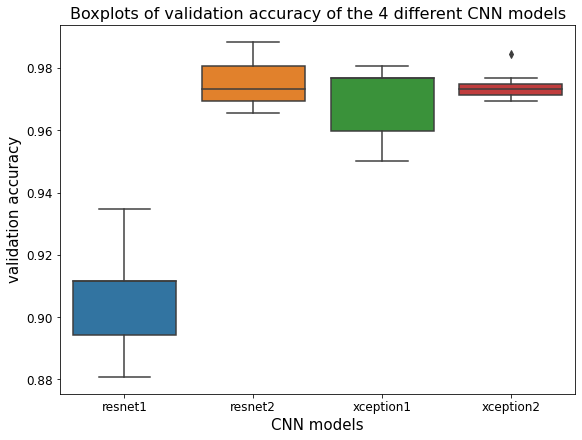

In [28]:
plt.subplots(1, 1, figsize=(8,6), constrained_layout=True)
accuracy_boxplot = sns.boxplot(x="variable", y="value", data=pd.melt(df_val_accuracy))

accuracy_boxplot.axes.set_title('Boxplots of validation accuracy of the 4 different CNN models', fontsize=16);
accuracy_boxplot.set_xlabel('CNN models', fontsize=15)
accuracy_boxplot.set_ylabel('validation accuracy', fontsize=15);
accuracy_boxplot.tick_params(labelsize=12)

The above side-by-side boxplots compare the validation accuracy of the four CNN models at the last five epochs of model training and validation process.  We see that the model named resnet2 and xception2 seem to be the winners with the best accuracy and recall close to 0.98. The model named xception1 appears to be the 3rd best model with the best accuracy close to 0.97. The resnet1 has validation accuracy and recall value around 0.91, shows the lowest performance.

The recall scores for both defective and ok classes of the four models are close to the accuracy. Thus, using recall score as the model performance evaluation criteria, we get the same conclusion as above.

The visual inspection gives us a rough idea of the model performance. Statistical tests such as McNemar are needed to quantify which models are the ultimate winners. We will perform the McNemar tests next. 

### Statistical comparison of model performance using McNemar tests

In [29]:
X_train, X_test, y_train,  y_test = train_test_split(X, target,
                                                     test_size = 0.2, 
                                                     stratify=target, 
                                                     random_state=7324, 
                                                     shuffle=True)

In [30]:
yhat_resnet1 = np.argmax(resnet1.predict(X_test), axis=1)
yhat_resnet2 = np.argmax(resnet2.predict(X_test), axis=1)
yhat_xception1 = np.argmax(xception1.predict(X_test), axis=1)
yhat_xception2 = np.argmax(xception2.predict(X_test), axis=1)

In [31]:
# y_test is the true y values from the test data
# model1_pred  is the predicted y values from model 1
# model2_pred is the predicted y values from model 2

def create_contingency_MacNemar(y_test, model1_pred, model2_pred):
    
    correct1_correct2 = 0  # model 1 predict correctly, model 2 also predict correctly
    correct1_wrong2 = 0 # model 1 predict correctly, model 2 predict wrong
    wrong1_correct2 = 0
    wrong1_wrong2 = 0
    
    for i in range(len(y_test)):
        if model1_pred[i] == y_test[i] and model2_pred[i] == y_test[i]:
            correct1_correct2 +=1
        elif model1_pred[i] == y_test[i] and model2_pred[i] != y_test[i]:
            correct1_wrong2 +=1
        elif model1_pred[i] != y_test[i] and model2_pred[i] == y_test[i]:
            wrong1_correct2 +=1
        else:
            wrong1_wrong2 +=1
    return [[correct1_correct2, correct1_wrong2], [wrong1_correct2, wrong1_wrong2]]
            
# https://machinelearningmastery.com/mcnemars-test-for-machine-learning/

# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar
# define contingency table

def cal_mcnemar(table):

    # calculate mcnemar test
    print(table)
    result = mcnemar(table, exact=True)
    # summarize the finding
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    # interpret the p-value
    alpha = 0.05
    if result.pvalue > alpha:
        print('fail to reject H0')
    else:
        print('reject H0')

 #### McNemar test for model 1 and  model 2

In [32]:
table = create_contingency_MacNemar(y_test, yhat_resnet1, yhat_resnet2)  
cal_mcnemar(table)

[[239, 1], [13, 7]]
statistic=1.000, p-value=0.002
reject H0


We reject the Null Hypothesis. Using significance level alpha = 0.05, we have sufficient evidence that model 1 and  model 2 are different from each other. 

The accuracy and recall values of model 2 is higher than model 1. Therefore, we conclude model 2 has a better performance than model 1. 

 #### McNemar test for model 1 and  model 3

In [33]:
table = create_contingency_MacNemar(y_test, yhat_resnet1, yhat_xception1)  
cal_mcnemar(table)

[[240, 0], [15, 5]]
statistic=0.000, p-value=0.000
reject H0


We reject the Null Hypothesis. Using significance level alpha = 0.05, we have sufficient evidence that model 1 and  model 3 are different from each other. 

The accuracy and recall values of model 3 is higher than model 1. Therefore, we conclude model 3 has a better performance than model 1.

 #### McNemar test for model 1 and  model 4

In [34]:
table = create_contingency_MacNemar(y_test, yhat_resnet1, yhat_xception2)  
cal_mcnemar(table)

[[234, 6], [15, 5]]
statistic=6.000, p-value=0.078
fail to reject H0


We fail to reject the Null Hypothesis. Using significance level alpha = 0.05, we do not have sufficient evidence that model 1 and  model 4 are different from each other.

 #### McNemar test for model 2 and  model 3

In [35]:
table = create_contingency_MacNemar(y_test, yhat_resnet2, yhat_xception1)  
cal_mcnemar(table)

[[249, 3], [6, 2]]
statistic=3.000, p-value=0.508
fail to reject H0


We fail to reject the Null Hypothesis. Using significance level alpha = 0.05, we do not have sufficient evidence that model 2 and  model 3 are different from each other.

 #### McNemar test for model 2 and  model 4

In [36]:
table = create_contingency_MacNemar(y_test, yhat_resnet2, yhat_xception2)  
cal_mcnemar(table)

[[244, 8], [5, 3]]
statistic=5.000, p-value=0.581
fail to reject H0


We fail to reject the Null Hypothesis. Using significance level alpha = 0.05, we do not have sufficient evidence that model 2 and  model 4 are different from each other. 

 #### McNemar test for model 3 and  model 4

In [37]:
table = create_contingency_MacNemar(y_test,  yhat_xception1, yhat_xception2)  
cal_mcnemar(table)

[[245, 10], [4, 1]]
statistic=4.000, p-value=0.180
fail to reject H0


We fail to reject the Null Hypothesis. Using significance level alpha = 0.05, we do not have sufficient evidence that model 3 and  model 4 are different from each other. 

The above McNemar tests show that model 2, model 3, and model 4 have comparable performance in recall values and accuracy. So they are the winner CNN models for casting defect prediction. Model 1 has far less superior performance and is not as good as the other three models. 

 ### A standard multi-layer perceptron (MLP) model


Results for cross-validation set 1
Epoch 1/150
18/18 [==============================] - 2s 64ms/step - loss: 0.2400 - accuracy: 0.6977 - val_loss: 0.2232 - val_accuracy: 0.7769
Epoch 2/150
18/18 [==============================] - 1s 35ms/step - loss: 0.2328 - accuracy: 0.7596 - val_loss: 0.2226 - val_accuracy: 0.7692
Epoch 3/150
18/18 [==============================] - 1s 38ms/step - loss: 0.1915 - accuracy: 0.8012 - val_loss: 0.2197 - val_accuracy: 0.7654
Epoch 4/150
18/18 [==============================] - 1s 37ms/step - loss: 0.1828 - accuracy: 0.8084 - val_loss: 0.1904 - val_accuracy: 0.7962
Epoch 5/150
18/18 [==============================] - 1s 37ms/step - loss: 0.1604 - accuracy: 0.8257 - val_loss: 0.3166 - val_accuracy: 0.6346
Epoch 6/150
18/18 [==============================] - 1s 39ms/step - loss: 0.2078 - accuracy: 0.7770 - val_loss: 0.1881 - val_accuracy: 0.8077
Epoch 7/150
18/18 [==============================] - 1s 37ms/step - loss: 0.1484 - accuracy: 0.8450 - val_loss: 

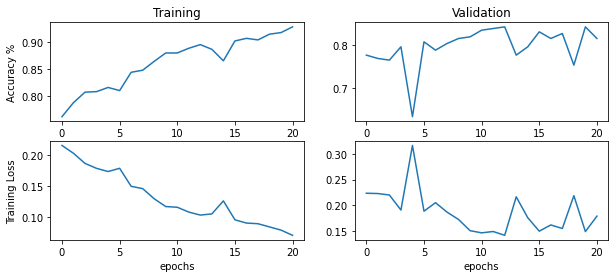

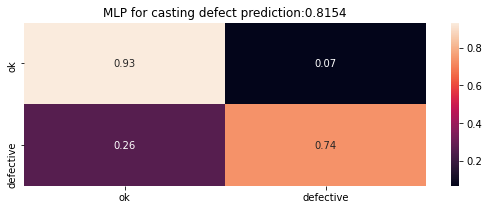

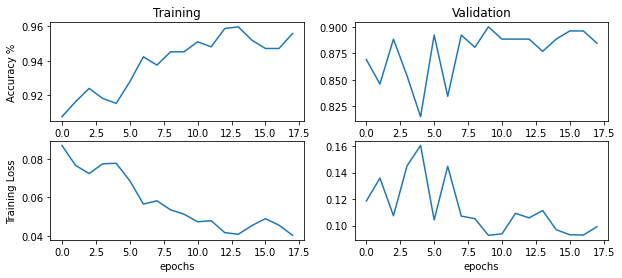

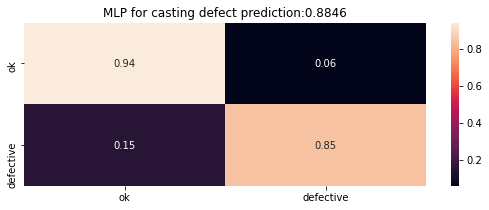

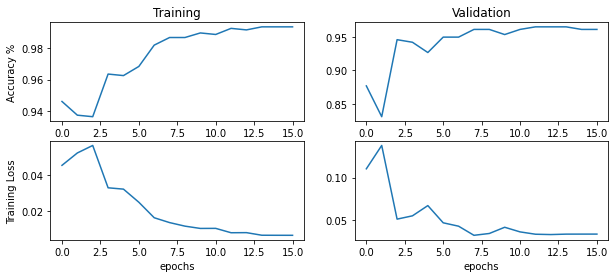

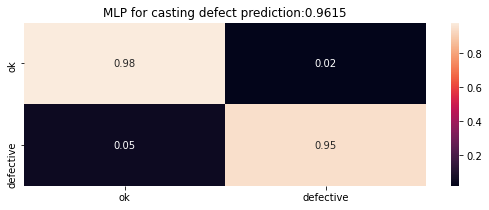

In [38]:
%%time 
# make a 3 layer keras MLP

mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=X_train.shape[1], units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='sgd',   # 'rmsprop',
              metrics=['accuracy']);


cv_val_accuracy_mlp = [] # this stores the val_accuracy for resnet2 from all cross_validation
cv_yhat_vec_mlp = [] # this stores the yhat_vec from all cross_validation

i = 0 

for train_index, test_index in cv_object.split(X, target):
    
    print()
    print("Results for cross-validation set", i+1)
    i +=1
    
    X_train, X_test = X[train_index], X[test_index]
    y_train,  y_test = target[train_index], target[test_index]
    
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)


    history = mlp.fit(X_train, y_train_ohe, 
        batch_size=60, epochs=150, 
        verbose=1, 
        validation_data=(X_test,y_test_ohe), 
        callbacks=[EarlyStopping(monitor='val_loss', patience=8)])  
    
    yhat = np.round(mlp.predict(X_test)) # yhat is one-hot encoded prediction of y
    yhat_vec = [] # yhat_vec stores prediction of y in a vector form
    
    # change yhat from one-hot encoded form to a vector form
    for j in range(len(yhat)):
        if yhat[j][1] == 1:
            yhat_vec.append(1)
        else:
            yhat_vec.append(0)
            
    cv_yhat_vec_mlp.append(yhat_vec)

    
    cv_val_accuracy_mlp.append(history.history['val_accuracy'])
    
    plt.figure(figsize=(10,4))
    
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'])
    plt.ylabel('Accuracy %')
    plt.title('Training')
    
    plt.subplot(2,2,2)
    plt.plot(history.history['val_accuracy'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')

    cr_mlp =  summarize_net(mlp, X_test, y_test, title_text='MLP for casting defect prediction:')
    
    if (i == num_cv_iterations):
      print('classification_report:\n', cr_mlp )
    
    print()
    print()


The three-layer multi-layer perceptron (MLP) model achieves around 96% accuracy and 96% recall value for defective class from three-fold cross validation training and testing.

### Compare the performance of the best convolutional network to the standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. 

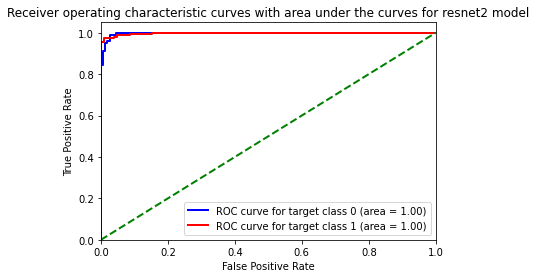

In [41]:
yhat_resnet2_onehot = resnet2.predict(X_test)

# need to onehot encode both y_test and yhat
y_test_onehot = pd.get_dummies(y_test).values

n_classes = y_test_onehot.shape[1]

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], yhat_resnet2_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), yhat_resnet2_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='blue',
         lw=lw, label='ROC curve for target class 0 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve for target class 1 (area = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curves with area under the curves for resnet2 model')
plt.legend(loc="lower right")
plt.show()

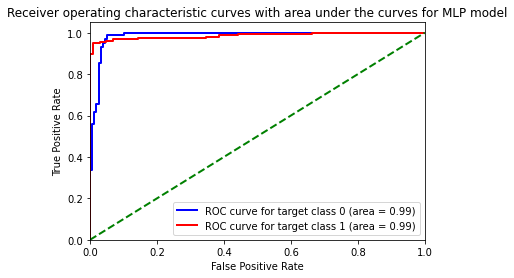

In [43]:
yhat_mlp_onehot = mlp.predict(X_test)
# need to onehot encode both y_test and yhat

y_test_onehot = pd.get_dummies(y_test).values

n_classes = y_test_onehot.shape[1]

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], yhat_mlp_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), yhat_mlp_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='blue',
         lw=lw, label='ROC curve for target class 0 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve for target class 1 (area = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curves with area under the curves for MLP model')
plt.legend(loc="lower right")
plt.show()

### Statistical comparison 
#### McNemar test for resnet2 (the best CNN model) and the three-layer multi-layer perceptron (MLP) model

In [44]:
yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)

In [45]:
yhat_resnet2 = np.argmax(resnet2.predict(X_test), axis=1)
table = create_contingency_MacNemar(y_test, yhat_mlp, yhat_resnet2)  
cal_mcnemar(table)

[[244, 6], [8, 2]]
statistic=6.000, p-value=0.791
fail to reject H0


We fail to reject the Null Hypothesis. Using significance level alpha = 0.05, we do not have sufficient evidence that the MLP model and the resnet2 model differ. 

The accuracy and recall values of the resnet2 model are similar to that of the MLP model. Therefore, we conclude that the resnet2 model and the MLP model have comparable performance. 

### Exceptional work

In [46]:
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train,  y_test = train_test_split(X, target,
                                                     test_size = 0.2, 
                                                     stratify=target, 
                                                     random_state=7324, )

y_train_ohe = to_categorical(y_train, NUM_CLASSES)
y_test_ohe = to_categorical(y_test, NUM_CLASSES)

In [47]:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)
       

X_train = np.squeeze(X_train, axis = 3)
X_test =  np.squeeze(X_test, axis = 3)

X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
X_test = np.repeat(X_test[..., np.newaxis], 3, -1)

94773248/94765736 [==============================] - 2s 0us/step


In [48]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [49]:
X_train.shape

(1040, 512, 512, 3)

In [50]:
X_test.shape

(260, 512, 512, 3)

In [51]:
%%time
x_train_resnet = res_no_top.predict(X_train)
x_test_resnet = res_no_top.predict(X_test)
print(x_train_resnet.shape)
print(x_test_resnet.shape)

(1040, 16, 16, 2048)
(260, 16, 16, 2048)
CPU times: user 30.9 s, sys: 26 s, total: 56.9 s
Wall time: 53.7 s


In [52]:

from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add, Flatten, Dense
from keras.layers import average, concatenate
from keras.models import Input, Model

input_x = Input(shape=x_train_resnet[0].shape)
x = Flatten()(input_x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)

predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

tansferlearning_model = Model(inputs=input_x, outputs=predictions)

tansferlearning_model.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 16, 16, 2048)]    0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 524288)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               104857800 
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 402       
Total params: 104,858,202
Trainable params: 104,858,202
Non-trainable params: 0
_________________________________________________________________


In [53]:
y_train_ohe_resnet = y_train_ohe[:x_train_resnet.shape[0]]

tansferlearning_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

tansferlearning_model.fit(x_train_resnet,y_train_ohe_resnet,
                          epochs=150, 
                          batch_size=128,
                          verbose=1, 
                          callbacks=[EarlyStopping(monitor='val_loss', patience=12)], 
                          validation_data=(x_test_resnet, y_test_ohe[:x_test_resnet.shape[0]]));

Epoch 1/150
9/9 [==============================] - 3s 294ms/step - loss: 339.9524 - accuracy: 0.5150 - val_loss: 17.8736 - val_accuracy: 0.6962
Epoch 2/150
9/9 [==============================] - 2s 226ms/step - loss: 28.9885 - accuracy: 0.6917 - val_loss: 62.7337 - val_accuracy: 0.6038
Epoch 3/150
9/9 [==============================] - 2s 235ms/step - loss: 33.3089 - accuracy: 0.6905 - val_loss: 18.2851 - val_accuracy: 0.7500
Epoch 4/150
9/9 [==============================] - 2s 218ms/step - loss: 10.2365 - accuracy: 0.8001 - val_loss: 45.7566 - val_accuracy: 0.4038
Epoch 5/150
9/9 [==============================] - 2s 224ms/step - loss: 25.4031 - accuracy: 0.6540 - val_loss: 21.8626 - val_accuracy: 0.6731
Epoch 6/150
9/9 [==============================] - 2s 234ms/step - loss: 19.2220 - accuracy: 0.6931 - val_loss: 17.6903 - val_accuracy: 0.6577
Epoch 7/150
9/9 [==============================] - 2s 224ms/step - loss: 13.7787 - accuracy: 0.7151 - val_loss: 8.1590 - val_accuracy: 0.7731

classification_report:
               precision    recall  f1-score   support

           0       0.96      0.67      0.79       104
           1       0.82      0.98      0.89       156

    accuracy                           0.86       260
   macro avg       0.89      0.83      0.84       260
weighted avg       0.87      0.86      0.85       260



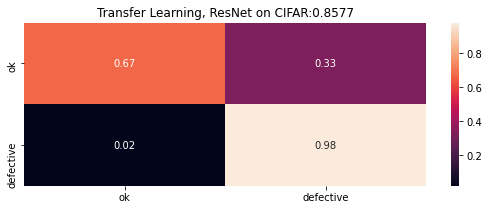

In [54]:
cr_tr= summarize_net(tansferlearning_model, x_test_resnet, y_test, title_text='Transfer Learning, ResNet on CIFAR:')
print('classification_report:\n', cr_tr )

 #### McNemar test for resnet2 (our best model) and  transfer learning model

In [55]:
yhat_transfer_learning = np.argmax(tansferlearning_model.predict(x_test_resnet), axis=1)

In [56]:
table = create_contingency_MacNemar(y_test, yhat_resnet2, yhat_transfer_learning)  
cal_mcnemar(table)

[[120, 12], [103, 25]]
statistic=12.000, p-value=0.000
reject H0


We reject the Null Hypothesis. Using significance level alpha = 0.05, we have sufficient evidence that resenet2 and  trasnfer learning model are different from each other. 

The accuracy and defect recall value of resnet2 is higher than transfer learning model. Therefore, we conclude resnet2 has a better performance than transfer learning model. 

#### Reference
[1]https://www.clearviewimaging.co.uk/blog/the-difference-between-computer-vision-and-machine-vision

[2] https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62